# Identify generic genes and pathways

**This notebook performs the following steps to identify generic genes:**
1. Simulates N gene expression experiments using [ponyo](https://github.com/ajlee21/ponyo)
2. Perform DE analysis to get association statistics for each gene

In this case the DE analysis is based on the experimental design of the template experiment, described in the previous [notebook](1_process_recount2_data.ipynb). The template experiment is [SRP012656](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE37764), which contains primary non-small cell lung adenocarcinoma tumors and adjacent normal tissues of 6 never-smoker Korean female patients. So the DE analysis is comparing tumor vs normal in this case.

3. For each gene, aggregate statsitics across all simulated experiments 
4. Rank genes based on this aggregated statistic (i.e. log fold change, or p-value)


**This notebook performs the following steps to identify generic gene sets (pathways):**
1. Using the same simulated experiments from above, perform GSEA analysis. This analysis will determine whether the genes contained in a gene set are clustered towards the beginning or the end of the ranked list of genes, where genes are ranked by say log fold change, indicating a correlation with change in expression.
2. For each gene set (pathway), aggregate statistics across all simulated experiments
3. Rank gene sets based on this aggregated statistic

**Evaluation:**
* We want to compare the ranking of genes identified using the above method compared to the ranking found from Crow et. al., which identified a set of genes as generic based on their ranking
* We want to compare the ranking of pathways identified using the above method compared to the ranking found from Powers et. al., which identified a set of pathways as generic based on their ranking
* This comparison will validate our method being used as a way to automatically identify generic genes and pathways.

In [1]:
%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2

import os
import sys
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
from sklearn.decomposition import PCA

from plotnine import (ggplot,
                      labs,  
                      geom_line, 
                      geom_point,
                      geom_errorbar,
                      aes, 
                      ggsave, 
                      theme_bw,
                      theme,
                      xlim,
                      ylim,
                      facet_wrap,
                      scale_color_manual,
                      guides, 
                      guide_legend,
                      element_blank,
                      element_text,
                      element_rect,
                      element_line,
                      coords)
from rpy2.robjects import pandas2ri
pandas2ri.activate()

from ponyo import utils, simulate_expression_data
from generic_expression_patterns_modules import calc, process

np.random.seed(123)

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
Using TensorFlow backend.


In [2]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../"))

config_file = os.path.abspath(os.path.join(base_dir,
                                           "configs",
                                           "config_human.tsv"))
params = utils.read_config(config_file)

In [3]:
# Load params
local_dir = params["local_dir"]
dataset_name = params['dataset_name']
NN_architecture = params['NN_architecture']
num_runs = params['num_simulated']
project_id = params['project_id']
metadata_col_id = params['metadata_colname']
template_data_file = params['template_data_file']
original_compendium_file = params['compendium_data_file']
normalized_compendium_file = params['normalized_compendium_data_file']
scaler_file = params['scaler_transform_file']
col_to_rank_genes = params['rank_genes_by']
col_to_rank_pathways = params['rank_pathways_by']
compare_genes = params['compare_genes']
statistic = params['gsea_statistic']

NN_dir = os.path.join(
    base_dir, 
    dataset_name, 
    "models", 
    NN_architecture)

# Load metadata file with grouping assignments for samples
sample_id_metadata_file = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "metadata",
    f"{project_id}_process_samples.tsv")

# Load pickled file
scaler = pickle.load(open(scaler_file, "rb"))

In [4]:
# Output files
gene_summary_file = os.path.join(
    base_dir, 
    dataset_name, 
    f"generic_gene_summary_{project_id}.tsv")

pathway_summary_file = os.path.join(
    base_dir, 
    dataset_name, 
    f"generic_pathway_summary_{project_id}.tsv")

### Simulate experiments using selected template experiment

In [5]:
"""# Simulate multiple experiments
for i in range(num_runs):
    simulate_expression_data.shift_template_experiment(
        normalized_compendium_file,
        project_id,
        metadata_col_id,
        NN_architecture,
        dataset_name,
        scaler,
        local_dir,
        base_dir,
        i)"""

'# Simulate multiple experiments\nfor i in range(num_runs):\n    simulate_expression_data.shift_template_experiment(\n        normalized_compendium_file,\n        project_id,\n        metadata_col_id,\n        NN_architecture,\n        dataset_name,\n        scaler,\n        local_dir,\n        base_dir,\n        i)'

Since this experiment contains both RNA-seq and smRNA-seq samples which are in different ranges so we will drop smRNA samples so that samples are within the same range. The analysis identifying these two subsets of samples can be found in this [notebook](../explore_data/0_explore_input_data.ipynb)

In [6]:
"""if os.path.exists(sample_id_metadata_file):
    # Read in metadata
    metadata = pd.read_csv(sample_id_metadata_file, sep='\t', header=0, index_col=0)
    
    # Get samples to be dropped
    sample_ids_to_drop = list(metadata[metadata["processing"] == "drop"].index)

    process.subset_samples(sample_ids_to_drop,
                           num_runs,
                           local_dir,
                           project_id)"""

'if os.path.exists(sample_id_metadata_file):\n    # Read in metadata\n    metadata = pd.read_csv(sample_id_metadata_file, sep=\'\t\', header=0, index_col=0)\n    \n    # Get samples to be dropped\n    sample_ids_to_drop = list(metadata[metadata["processing"] == "drop"].index)\n\n    process.subset_samples(sample_ids_to_drop,\n                           num_runs,\n                           local_dir,\n                           project_id)'

In [7]:
# Round simulated read counts to int in order to run DESeq
process.recast_int(num_runs, local_dir, project_id)

### Differential expression analysis

In [8]:
# Load metadata file with grouping assignments for samples
metadata_file = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "metadata",
    project_id+"_groups.tsv")

In [9]:
%%R
# Select 59
# Run one time
#if (!requireNamespace("BiocManager", quietly = TRUE))
#    install.packages("BiocManager")
#BiocManager::install("DESeq2")

NULL


In [10]:
%%R
# Load the DESeq2 library
suppressPackageStartupMessages(library("DESeq2"))

In [11]:
# Check ordering of sample ids is consistent between gene expression data and metadata
process.compare_and_reorder_samples(template_data_file, metadata_file)

sample ids are ordered correctly


In [12]:
%%R -i metadata_file -i project_id -i template_data_file -i local_dir

source('../generic_expression_patterns_modules/DE_analysis.R')

get_DE_stats_DESeq(metadata_file,
             project_id, 
             template_data_file,
             "template",
             local_dir,
             "real")

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: estimating size factors

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: estimating dispersions

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: gene-wise dispersion estimates

  warnings.warn(x, RRuntimeWarni

[1] "Checking sample ordering..."
[1] TRUE


In [13]:
# Check number of DEGs
template_DE_stats_file = os.path.join(
        local_dir,
        "DE_stats",
        f"DE_stats_template_data_{project_id}_real.txt")

template_DE_stats = pd.read_csv(template_DE_stats_file, sep="\t", header=0, index_col=0)

selected = template_DE_stats[(template_DE_stats['padj']<0.01) & (abs(template_DE_stats['log2FoldChange'])>1)]
print(selected.shape)

(3283, 6)


In [14]:
# Check ordering of sample ids is consistent between gene expression data and metadata
for i in range(num_runs):
    simulated_data_file = os.path.join(
        local_dir,
        "pseudo_experiment",
        f"selected_simulated_data_{project_id}_{i}.txt")
        
    process.compare_and_reorder_samples(simulated_data_file, metadata_file)

sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly


In [15]:
%%R -i metadata_file -i project_id -i base_dir -i local_dir -i num_runs

source('../generic_expression_patterns_modules/DE_analysis.R')

num_sign_DEGs_simulated <- c()

for (i in 0:(num_runs-1)){
    simulated_data_file <- paste(local_dir, 
                                 "pseudo_experiment/selected_simulated_data_",
                                 project_id,
                                 "_", 
                                 i,
                                 ".txt",
                                 sep="")
    
    get_DE_stats_DESeq(metadata_file,
                       project_id, 
                       simulated_data_file,
                       "simulated",
                       local_dir,
                       i)
}

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: -- replacing outliers and refitting for 1 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: -- replacing outliers and refitting for 2 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: -- replacing outliers and refitting for 12 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-

[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checki

**Validation:**
* As a quick validation, [Kim et. al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3566005/) found 1459 DEGs (543 upregulated and 916 downregulated) using used the Bowtie and NEUMA applications for the mapping and quantification of RNA-Seq data. They used *edgeR* with a rigorous filtering procedure based on false discovery rates, minimum applicable patient numbers, and gene expression levels was devised to select reliable sets of DEGs and DEIs (see File S8 for details). For the

* Our results found ~3K DEGs which is close enough in range given that the data was processed using different methods. recount2 resource were aligned with the splice-aware Rail-RNA aligner

### Rank genes

In [16]:
# Concatenate simulated experiments
simulated_DE_stats_all = process.concat_simulated_data(local_dir, num_runs, project_id, 'DE')

print(simulated_DE_stats_all.shape)

(444700, 7)


In [17]:
# Take absolute value of logFC and t statistic
simulated_DE_stats_all = process.abs_value_stats(simulated_DE_stats_all)

In [18]:
# Aggregate statistics across all simulated experiments
simulated_DE_summary_stats = calc.aggregate_stats(col_to_rank_genes,
                                                  simulated_DE_stats_all,
                                                  'DE')

In [19]:
# Load association statistics for template experiment
template_DE_stats_file = os.path.join(
    local_dir,
    "DE_stats",
    "DE_stats_template_data_"+project_id+"_real.txt")

template_DE_stats = pd.read_csv(
    template_DE_stats_file,
    header=0,
    sep='\t',
    index_col=0)

# Take absolute value of logFC and t statistic
template_DE_stats = process.abs_value_stats(template_DE_stats)

# Rank genes in template experiment
template_DE_stats = calc.rank_genes_or_pathways(col_to_rank_genes,      
                                                template_DE_stats,
                                                True)

In [20]:
# Rank genes in simulated experiments
simulated_DE_summary_stats = calc.rank_genes_or_pathways(col_to_rank_genes,
                                                         simulated_DE_summary_stats,
                                                         False)

### Gene summary table

In [21]:
summary_gene_ranks = process.generate_summary_table(template_DE_stats,
                                                   simulated_DE_summary_stats,
                                                   col_to_rank_genes,
                                                   local_dir)

summary_gene_ranks.head()

(17788, 13)


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,Gene ID,Adj P-value (Real),Rank (Real),Test statistic (Real),Median adj p-value (simulated),Rank (simulated),Mean test statistic (simulated),Std deviation (simulated),Number of experiments (simulated),Z score
PAX7,PAX7,5.947105e-13,17601.0,10.693976,0.093447,12395.0,0.736720,0.626895,25,15.883459
PRAME,PRAME,2.957595e-15,17600.0,8.664826,0.000081,14911.0,1.321843,1.072240,25,6.848266
SLCO1B3,SLCO1B3,5.295483e-04,17599.0,8.325555,0.027025,14926.0,1.193922,1.007753,25,7.076763
KCNC2,KCNC2,1.984730e-10,17598.0,8.230400,0.018207,13818.0,1.223429,1.217960,24,5.753040
HOTAIR,HOTAIR,3.121660e-10,17597.0,8.228151,0.000001,16366.0,1.899140,1.462285,25,4.328165


In [22]:
summary_gene_ranks.to_csv(
    gene_summary_file, sep='\t')

### GSEA 
**Goal:** To detect modest but coordinated changes in prespecified sets of related genes (i.e. those genes in the same pathway or share the same GO term).

1. Ranks all genes based using DE association statistics. In this case we used the p-value scores to rank genes. logFC returned error -- need to look into this.
2. An enrichment score (ES) is defined as the maximum distance from the middle of the ranked list. Thus, the enrichment score indicates whether the genes contained in a gene set are clustered towards the beginning or the end of the ranked list (indicating a correlation with change in expression). 
3. Estimate the statistical significance of the ES by a phenotypic-based permutation test in order to produce a null distribution for the ES( i.e. scores based on permuted phenotype)

In [23]:
%%R
# Select 59
# Run one time
#if (!requireNamespace("BiocManager", quietly = TRUE))
#    install.packages("BiocManager")
#BiocManager::install("GSA")
#BiocManager::install("fgsea")

NULL


In [24]:
%%R
suppressPackageStartupMessages(library("GSA"))
suppressPackageStartupMessages(library("fgsea"))

In [25]:
# Load pathway data
hallmark_DB_file = os.path.join(
    local_dir,
    "hallmark_DB.gmt")

In [26]:
%%R -i template_DE_stats_file -i hallmark_DB_file -i statistic -o template_enriched_pathways

source('../generic_expression_patterns_modules/GSEA_analysis.R')
template_enriched_pathways <- find_enriched_pathways(template_DE_stats_file, hallmark_DB_file, statistic)

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [27]:
print(template_enriched_pathways.shape)
template_enriched_pathways[template_enriched_pathways['padj'] < 0.05].sort_values(by='padj').head()

(50, 8)


,pathway,pval,padj,ES,NES,nMoreExtreme,size,leadingEdge
12,HALLMARK_E2F_TARGETS,0.000124,0.002064,0.545636,1.931764,0.0,185,None
17,HALLMARK_G2M_CHECKPOINT,0.000124,0.002064,0.544469,1.928160,0.0,184,None
18,HALLMARK_GLYCOLYSIS,0.000123,0.002064,0.518884,1.847156,0.0,196,None
1,HALLMARK_ALLOGRAFT_REJECTION,0.000510,0.002095,-0.393586,-1.613112,0.0,180,None
44,HALLMARK_TNFA_SIGNALING_VIA_NFKB,0.000545,0.002095,-0.672227,-2.778153,0.0,197,None


In [28]:
template_enriched_pathways[template_enriched_pathways['padj'] >= 0.05].sort_values(by='padj')[:15]

,pathway,pval,padj,ES,NES,nMoreExtreme,size,leadingEdge
0,HALLMARK_ADIPOGENESIS,0.027254,0.061940,-0.306933,-1.263288,51.0,187,None
7,HALLMARK_BILE_ACID_METABOLISM,0.065157,0.141646,-0.324908,-1.243759,163.0,110,None
19,HALLMARK_HEDGEHOG_SIGNALING,0.089961,0.187418,-0.433641,-1.332876,318.0,33,None
42,HALLMARK_SPERMATOGENESIS,0.116939,0.216554,0.359222,1.222346,893.0,129,None
15,HALLMARK_ESTROGEN_RESPONSE_LATE,0.109140,0.216554,0.340342,1.207868,885.0,191,None
49,HALLMARK_XENOBIOTIC_METABOLISM,0.115711,0.216554,-0.278462,-1.148782,217.0,191,None
9,HALLMARK_COAGULATION,0.126230,0.225411,-0.297246,-1.167515,294.0,131,None
5,HALLMARK_APICAL_SURFACE,0.163813,0.278028,-0.368498,-1.200632,554.0,43,None
36,HALLMARK_P53_PATHWAY,0.172377,0.278028,-0.269050,-1.108967,326.0,189,None
34,HALLMARK_NOTCH_SIGNALING,0.170451,0.278028,-0.400476,-1.220898,607.0,32,None


### Quick validation
* GSEA seems to be working as expected when we visualized the distribution of enriched pathways. Distribution of enrichment scores are consistent with what we would expect for not significant pathways (i.e. genes are evenly distributed) and significant pathways (i.e. genes are clustered to one end). 

<img src="GSEA examination.png" width="800">

* [Kim et. al](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3566005/) *used the Ingenuity Pathway Analysis (IPA) software, which uses a database of evidence manually compiled from the literature. The most enriched term in the diseases and disorders category was cancer (p value = 2.13E-42), which supports the validity of our gene set. Other relevant terms in the molecular and cellular functions category included cellular growth and proliferation (p value = 1.71E-17) and cell death (p value = 1.97E-17). The IPA results are presented in Figure S9 in File S8. Gene ontology (GO) analysis produced similar results to IPA, albeit in a less comprehensive manner (data not shown).*

* We found the following pathways as being signifcantly enriched in DEGs: HALLMARK_G2M_CHECKPOINT, TNFA_SIGNALING, INFLAMMATORY_RESPONSE, APOPTOSIS, HYPOXIA. These pathways are expected and consistent with what the publication found (cancer pathways, cell death pathways, cell proliferation).

* However, there are a few pathways that were not found to be significant but we initially expect to find given this is a cancer dataset: P53, NOTCH_SIGNALING, DNA_REPAIR, HALLMARK_KRAS_SIGNALING_UP. First, we do not think there is an issue with the GSEA implementation, given what we reported above. Second, the original publication did not explicitly mention the p53 pathway. Last, [Tang et. al](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6036325/) found the p53 pathway to be significantly enriched using 80 tumor and 20 normal samples. And [Gibbons et. al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3925633/) found that p53 mutations was high (46%) in non-small cell lung adenocarcinoma patients. We suspect the reason for the p53 pathway not being significant in this case might be due to the small sample size here (6 paired samples). So for now we will move forward with our GSEA analysis.

In [29]:
%%R -i project_id -i local_dir -i hallmark_DB_file -i num_runs -i statistic

source('../generic_expression_patterns_modules/GSEA_analysis.R')

for (i in 0:(num_runs-1)){
    simulated_DE_stats_file <- paste(local_dir, 
                                 "DE_stats/DE_stats_simulated_data_", 
                                 project_id,
                                 "_", 
                                 i,
                                 ".txt",
                                 sep="")
    
    out_file = paste(local_dir, 
                     "GSEA_stats/GSEA_stats_simulated_data_",
                     project_id,
                     "_",
                     i,
                     ".txt", 
                     sep="")
    
    enriched_pathways <- find_enriched_pathways(simulated_DE_stats_file, hallmark_DB_file, statistic) 
    
    # Remove column with leading edge since its causing parsing issues
    write.table(as.data.frame(enriched_pathways[1:7]), file = out_file, row.names = F, sep = "\t")
    }

### Rank pathways 

In [30]:
# Concatenate simulated experiments
simulated_GSEA_stats_all = process.concat_simulated_data(local_dir, num_runs, project_id, 'GSEA')
simulated_GSEA_stats_all.set_index('pathway', inplace=True)
print(simulated_GSEA_stats_all.shape)

(1250, 6)


In [31]:
simulated_GSEA_stats_all.head()

,pval,padj,ES,NES,nMoreExtreme,size
pathway,,,,,,
HALLMARK_ADIPOGENESIS,0.011855,0.025822,-0.312835,-1.391659,50,186
HALLMARK_ALLOGRAFT_REJECTION,0.014829,0.029657,-0.309187,-1.370592,63,181
HALLMARK_ANDROGEN_RESPONSE,0.009781,0.024518,0.383604,1.507231,53,94
HALLMARK_ANGIOGENESIS,0.052609,0.082201,-0.428873,-1.429611,239,35
HALLMARK_APICAL_JUNCTION,0.232060,0.290075,-0.245929,-1.098277,995,191


In [32]:
# Aggregate statistics across all simulated experiments
simulated_GSEA_summary_stats = calc.aggregate_stats(col_to_rank_pathways,
                                                    simulated_GSEA_stats_all,
                                                    'GSEA')

simulated_GSEA_summary_stats.head()

padj                          
                                median      mean       std count
pathway                                                         
HALLMARK_ADIPOGENESIS         0.668583  0.532101  0.453903    25
HALLMARK_ALLOGRAFT_REJECTION  0.001668  0.108823  0.277667    25
HALLMARK_ANDROGEN_RESPONSE    0.217205  0.361969  0.356939    24
HALLMARK_ANGIOGENESIS         0.207668  0.287011  0.277594    25
HALLMARK_APICAL_JUNCTION      0.507154  0.531399  0.339702    25

In [33]:
# Load association statistics for template experiment
template_GSEA_stats = template_enriched_pathways.iloc[:,:-1]
template_GSEA_stats.set_index('pathway', inplace=True)

template_GSEA_stats.head()

# Rank genes in template experiment
template_GSEA_stats = calc.rank_genes_or_pathways(col_to_rank_pathways,
                                                  template_GSEA_stats,
                                                  True)

In [34]:
# Rank genes in simulated experiments
simulated_GSEA_summary_stats = calc.rank_genes_or_pathways(col_to_rank_pathways,
                                                           simulated_GSEA_summary_stats,
                                                           False)

In [35]:
simulated_GSEA_summary_stats.head()

padj                           ranking
                                  median      mean       std count        
pathway                                                                   
HALLMARK_INFLAMMATORY_RESPONSE  0.001280  0.107057  0.257714    25    50.0
HALLMARK_ALLOGRAFT_REJECTION    0.001668  0.108823  0.277667    25    49.0
HALLMARK_MYOGENESIS             0.001694  0.097991  0.254319    25    47.5
HALLMARK_COAGULATION            0.001694  0.064172  0.153658    25    47.5
HALLMARK_KRAS_SIGNALING_DN      0.001901  0.064076  0.136747    25    46.0

In [36]:
template_GSEA_stats.head()

,pval,padj,ES,NES,nMoreExtreme,size,ranking
pathway,,,,,,,
HALLMARK_GLYCOLYSIS,0.000123,0.002064,0.518884,1.847156,0.0,196,49.0
HALLMARK_G2M_CHECKPOINT,0.000124,0.002064,0.544469,1.928160,0.0,184,49.0
HALLMARK_E2F_TARGETS,0.000124,0.002064,0.545636,1.931764,0.0,185,49.0
HALLMARK_INFLAMMATORY_RESPONSE,0.000545,0.002095,-0.522611,-2.159824,0.0,197,42.5
HALLMARK_IL2_STAT5_SIGNALING,0.000534,0.002095,-0.433946,-1.790899,0.0,193,42.5


### Pathway summary table

In [37]:
summary_pathway_ranks = process.generate_summary_table(template_GSEA_stats,
                                                       simulated_GSEA_summary_stats,
                                                       col_to_rank_pathways,
                                                       local_dir)

summary_pathway_ranks.head()

(50, 12)


,Gene ID,Adj P-value (Real),Rank (Real),Test statistic (Real),Median adj p-value (simulated),Rank (simulated),Mean test statistic (simulated),Std deviation (simulated),Number of experiments (simulated),Z score
pathway,,,,,,,,,,
HALLMARK_GLYCOLYSIS,HALLMARK_GLYCOLYSIS,0.002064,49.0,0.002064,0.080578,32.0,0.278431,0.375113,18,-0.736756
HALLMARK_G2M_CHECKPOINT,HALLMARK_G2M_CHECKPOINT,0.002064,49.0,0.002064,0.344405,28.0,0.464847,0.473616,21,-0.977127
HALLMARK_E2F_TARGETS,HALLMARK_E2F_TARGETS,0.002064,49.0,0.002064,0.025826,40.5,0.424038,0.477743,21,-0.883263
HALLMARK_INFLAMMATORY_RESPONSE,HALLMARK_INFLAMMATORY_RESPONSE,0.002095,42.5,0.002095,0.001280,50.0,0.107057,0.257714,25,-0.407282
HALLMARK_IL2_STAT5_SIGNALING,HALLMARK_IL2_STAT5_SIGNALING,0.002095,42.5,0.002095,0.048287,35.0,0.207629,0.297119,25,-0.691758


In [38]:
summary_pathway_ranks.sort_values(by="Rank (simulated)", ascending=False)

,Gene ID,Adj P-value (Real),Rank (Real),Test statistic (Real),Median adj p-value (simulated),Rank (simulated),Mean test statistic (simulated),Std deviation (simulated),Number of experiments (simulated),Z score
pathway,,,,,,,,,,
HALLMARK_INFLAMMATORY_RESPONSE,HALLMARK_INFLAMMATORY_RESPONSE,0.002095,42.5,0.002095,0.001280,50.0,0.107057,0.257714,25,-0.407282
HALLMARK_ALLOGRAFT_REJECTION,HALLMARK_ALLOGRAFT_REJECTION,0.002095,42.5,0.002095,0.001668,49.0,0.108823,0.277667,25,-0.384374
HALLMARK_MYOGENESIS,HALLMARK_MYOGENESIS,0.002095,42.5,0.002095,0.001694,47.5,0.097991,0.254319,25,-0.377068
HALLMARK_COAGULATION,HALLMARK_COAGULATION,0.225411,23.0,0.225411,0.001694,47.5,0.064172,0.153658,25,1.049333
HALLMARK_KRAS_SIGNALING_DN,HALLMARK_KRAS_SIGNALING_DN,0.023637,34.0,0.023637,0.001901,46.0,0.064076,0.136747,25,-0.295721
HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,0.527514,13.0,0.527514,0.003094,45.0,0.130889,0.285612,25,1.388679
HALLMARK_COMPLEMENT,HALLMARK_COMPLEMENT,0.002095,42.5,0.002095,0.004046,44.0,0.119066,0.250730,25,-0.466522
HALLMARK_HEME_METABOLISM,HALLMARK_HEME_METABOLISM,0.024893,33.0,0.024893,0.013128,43.0,0.202454,0.348393,25,-0.509656
HALLMARK_KRAS_SIGNALING_UP,HALLMARK_KRAS_SIGNALING_UP,0.043486,32.0,0.043486,0.016890,42.0,0.108047,0.221940,25,-0.290897


In [39]:
summary_pathway_ranks.to_csv(
    pathway_summary_file, sep='\t')

### Compare gene ranking
Studies have found that there are some genes that are more likely to be differentially expressed even across a wide range of experimental designs. These *generic genes* are not necessarily specific to the biological process being studied but instead represents a more systematic change. 

We want to compare the ability to detect these generic genes using our method vs those found by [Crow et. al. publication](https://www.pnas.org/content/pnas/116/13/6491.full.pdf). Their genes are ranked 0 = not commonly DE; 1 = commonly DE. Genes by the number differentially expressed gene sets they appear in and then ranking genes by this score.

0.28613028665195755 0.0 0.2722567413305808 0.30077365400771444


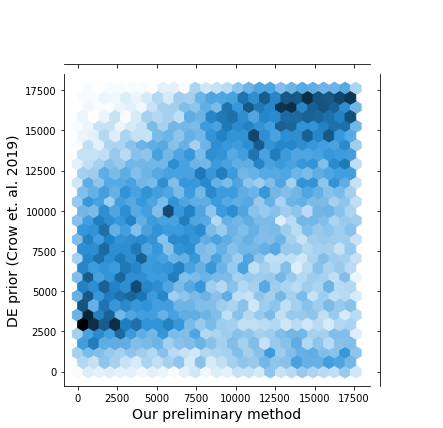

In [40]:
if compare_genes:
    # Get generic genes identified by Crow et. al.
    DE_prior_file = params['reference_gene_file']
    ref_gene_col = params['reference_gene_name_col']
    ref_rank_col = params['reference_rank_col']
    
    # Merge our ranking and reference ranking
    shared_gene_rank_df = process.merge_ranks_to_compare(
        summary_gene_ranks,
        DE_prior_file,
        ref_gene_col,
        ref_rank_col)
    
    if max(shared_gene_rank_df["Rank (simulated)"]) != max(shared_gene_rank_df[ref_rank_col]):
        shared_gene_rank_scaled_df = process.scale_reference_ranking(shared_gene_rank_df, ref_rank_col)
        
    # Note: These lowly expressed genes were not pre-filtered before DESeq
    # (Micheal Love, author of DESeq2): In our DESeq2 paper we discuss a case where estimation of dispersion is difficult 
    # for genes with very, very low average counts. See the methods. 
    # However it doesn't really effect the outcome because these genes have almost no power for detecting 
    # differential expression. Effects runtime though.
    shared_gene_rank_scaled_df = shared_gene_rank_scaled_df[~shared_gene_rank_scaled_df['Rank (simulated)'].isna()]
    
    # Get correlation
    r, p, ci_low, ci_high = calc.spearman_ci(0.95,
                                             shared_gene_rank_scaled_df,
                                             1000,
                                             'DE')
    print(r, p, ci_low, ci_high)
    
    # Plot our ranking vs published ranking
    fig_file = os.path.join(
        local_dir, 
        "gene_ranking_"+col_to_rank_genes+".svg")

    fig = sns.jointplot(data=shared_gene_rank_scaled_df,
                        x='Rank (simulated)',
                        y=ref_rank_col,
                        kind='hex',
                        marginal_kws={'color':'white'})
    fig.set_axis_labels("Our preliminary method", "DE prior (Crow et. al. 2019)", fontsize=14)

    fig.savefig(fig_file,
                format='svg',
                bbox_inches="tight",
                transparent=True,
                pad_inches=0,
                dpi=300,)

**Takeaway:**
Based on the correlation plot, we can see that our simulation method is very good at capturing variability in genes that are very low or very high in the DE rank (i.e. are significantly differentially expressed often across different studies). These results serve to validate that our method can be used to identify these generic genes, as we were able to recapitulate the some of the generic genes as those identified by Crow et. al. Additionally, our method extends the Crow et. al. work, which used array data, and since here we used RNA-seq.

### Compare pathway ranking try 1

Studies have found that there are some pathways (gene sets) that are more likely to be significantly enriched in DEGs across a wide range of experimental designs. These generic pathways are not necessarily specific to the biological process being studied but instead represents a more systematic change.

We want to compare the ability to detect these generic pathways using our method vs those found by [Powers et. al.](https://www.biorxiv.org/content/10.1101/259440v1.full.pdf) publication.  We will use the `Hallmarks_qvalues_GSEAPreranked.csv` file from https://www.synapse.org/#!Synapse:syn11806255 as a reference. The file contains the q-value (adjusted p-value) for the test: given the enrichment score (ES) of the experiment is significant compared to the null distribution of enrichment scores, where the null set is generated from permuted gene sets. For each gene set (pathway) they calculate the q-value using this test. 


To get a `reference ranking`, we calculate the fraction of experiments that a given pathway was significant (q-value <0.05) and use this rank pathways. `Our ranking` is to rank pathways based on the median q-value across the simulated experiments. We can then compare `our ranking` versus the `reference ranking.`

In [43]:
# Load Powers et. al. results file
powers_rank_file = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "metadata",
    "Hallmarks_qvalues_GSEAPreranked.csv")

In [44]:
# Read Powers et. al. data
# This file contains qvalue results for hallmark pathways across ~400 experiments
powers_rank_df = pd.read_csv(powers_rank_file, header=0, index_col=0)
powers_rank_df.drop(['Category'], axis=1, inplace=True)
print(powers_rank_df.shape)
powers_rank_df.head()

(50, 443)


,GSE10281_DEG_Expt1_Control_vs_Group1_qval,GSE10299_DEG_Expt1_Control_vs_Group1_qval,GSE10299_DEG_Expt1_Control_vs_Group2_qval,GSE10311_DEG_Expt1_Control_vs_Group1_qval,GSE10410_DEG_Expt1_Control_vs_Group1_qval,GSE10410_DEG_Expt1_Control_vs_Group2_qval,GSE10592_DEG_Expt1_Control_vs_Group1_qval,GSE10592_DEG_Expt2_Control_vs_Group1_qval,GSE11142_DEG_Expt1_Control_vs_Group1_qval,GSE11285_DEG_Expt1_Control_vs_Group1_qval,...,GSE79761_DEG_Expt1_Control_vs_Group2_qval,GSE79761_DEG_Expt1_Control_vs_Group3_qval,GSE83120_DEG_Expt1_Control_vs_Group1_qval,GSE83491_DEG_Expt1_Control_vs_Group1_qval,GSE83491_DEG_Expt2_Control_vs_Group1_qval,GSE8588_DEG_Expt1_Control_vs_Group1_qval,GSE8588_DEG_Expt1_Control_vs_Group2_qval,GSE8597_DEG_Expt1_Control_vs_Group1_qval,GSE8658_DEG_Expt1_Control_vs_Group1_qval,GSE9988_DEG_Expt1_Control_vs_Group1_qval
Term,,,,,,,,,,,,,,,,,,,,,
HALLMARK_APICAL_JUNCTION,0.010497,0.994108,0.045536,0.498151,0.538082,0.429205,0.355439,0.236627,0.767614,0.858065,...,0.637333,0.019621,0.086923,0.453315,0.730539,0.005366,0.863592,0.102867,0.639821,0.465678
HALLMARK_APICAL_SURFACE,0.443835,0.598008,0.181818,0.407927,0.130422,0.588732,0.192183,0.003519,1.000000,0.809823,...,0.260565,0.018686,0.691567,0.588169,1.000000,0.172392,0.657082,0.008060,0.618102,0.229456
HALLMARK_PEROXISOME,0.110897,0.988705,0.118807,0.094770,0.004288,0.115514,0.172297,0.035202,0.682219,0.393990,...,0.447485,0.380294,0.058549,0.110354,0.215365,0.006037,0.034110,0.331770,0.005224,1.000000
HALLMARK_ADIPOGENESIS,0.011177,0.461255,0.171288,0.020412,0.010720,0.000000,0.191663,0.846586,0.895637,0.056589,...,0.604963,0.805532,0.054415,0.022888,0.000000,0.735339,0.636778,0.649874,0.000000,0.435622
HALLMARK_ANGIOGENESIS,0.006014,0.380219,0.663985,0.992954,0.175682,0.010256,0.004750,0.015640,1.000000,0.402218,...,0.007489,0.023545,0.965871,0.035213,0.646400,0.004025,0.209530,0.007165,0.181685,0.108067


In [45]:
# Count the number of experiments where a given pathway was found to be enriched (qvalue < 0.05)
total_num_experiments = powers_rank_df.shape[1]
frac_enriched_pathways = ((powers_rank_df< 0.05).sum(axis=1)/total_num_experiments)

# Rank pathways from 0-50, 50 indicating that the pathways was frequently enriched
pathway_ranks = frac_enriched_pathways.rank()

powers_rank_stats_df = pd.DataFrame(
    data={'Fraction enriched': frac_enriched_pathways.values,
          'Powers Rank':pathway_ranks.values
         },
    index=powers_rank_df.index
)
powers_rank_stats_df.head()

,Fraction enriched,Powers Rank
Term,,
HALLMARK_APICAL_JUNCTION,0.124153,4.0
HALLMARK_APICAL_SURFACE,0.128668,5.5
HALLMARK_PEROXISOME,0.148984,7.5
HALLMARK_ADIPOGENESIS,0.182844,15.0
HALLMARK_ANGIOGENESIS,0.191874,16.5


In [46]:
# Save reference file for input into comparison
powers_rank_processed_file = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "metadata",
    "Hallmarks_qvalues_GSEAPreranked_processed.tsv")

powers_rank_stats_df.to_csv(powers_rank_processed_file, sep="\t", )

-0.12186862103010433 0.39917567922477715 -0.3837052717019639 0.1563116149952175


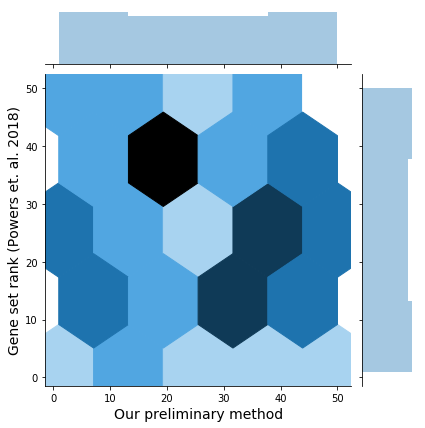

In [47]:
if compare_genes:
    # Get column headers for generic pathways identified by Powers et. al.
    ref_gene_col='index'
    ref_rank_col = 'Powers Rank'
    
    # Merge our ranking and reference ranking
    shared_pathway_rank_df = process.merge_ranks_to_compare(
        summary_pathway_ranks,
        powers_rank_processed_file,
        ref_gene_col,
        ref_rank_col
        )
    
    if max(shared_pathway_rank_df["Rank (simulated)"]) != max(shared_pathway_rank_df[ref_rank_col]):
        shared_pathway_rank_scaled_df = process.scale_reference_ranking(shared_pathway_rank_df, ref_rank_col)
    else:
        shared_pathway_rank_scaled_df = shared_pathway_rank_df
        
    # Note: These lowly expressed genes were not pre-filtered before DESeq
    # (Micheal Love, author of DESeq2): In our DESeq2 paper we discuss a case where estimation of dispersion is difficult 
    # for genes with very, very low average counts. See the methods. 
    # However it doesn't really effect the outcome because these genes have almost no power for detecting 
    # differential expression. Effects runtime though.
    
    shared_pathway_rank_scaled_df = shared_pathway_rank_scaled_df[~shared_pathway_rank_scaled_df['Rank (simulated)'].isna()]
    
    # Get correlation
    r, p, ci_low, ci_high = calc.spearman_ci(0.95,
                                             shared_pathway_rank_scaled_df,
                                             1000,
                                             'GSEA')
    print(r, p, ci_low, ci_high)
    
    # Plot our ranking vs published ranking
    fig_file = os.path.join(
        local_dir, 
        "pathway_ranking_"+col_to_rank_pathways+".svg")

    fig = sns.jointplot(data=shared_pathway_rank_scaled_df,
                        x='Rank (simulated)',
                        y=ref_rank_col,
                        kind='hex'
                       )
    fig.set_axis_labels("Our preliminary method", "Gene set rank (Powers et. al. 2018)", fontsize=14)

The above shows that there is no correlation between our ranking (where pathways were ranked using median adjusted p-value score across simulated experiments) vs Powers et. al. ranking (where pathways were ranked based on the fraction of experiments they had adjusted p-value < 0.05). This is using the same workflow used to compare ranking of genes. Next let's try to use the fraction of adjusted p-value < 0.05 for our method and re-compare.

In [48]:
simulated_GSEA_stats_all["significant"] = simulated_GSEA_stats_all['padj']<0.05
simulated_GSEA_stats_all_new = (simulated_GSEA_stats_all.groupby(['pathway'])["significant"].
                                sum()/num_runs).to_frame(name="Fraction enriched")
simulated_GSEA_stats_all_new["Rank (simulated)"] = simulated_GSEA_stats_all_new.rank()

print(simulated_GSEA_stats_all_new.shape)
simulated_GSEA_stats_all_new.head()

(50, 2)


,Fraction enriched,Rank (simulated)
pathway,,
HALLMARK_ADIPOGENESIS,0.28,26.5
HALLMARK_ALLOGRAFT_REJECTION,0.76,46.0
HALLMARK_ANDROGEN_RESPONSE,0.32,30.0
HALLMARK_ANGIOGENESIS,0.20,20.5
HALLMARK_APICAL_JUNCTION,0.04,9.5


0.07762580160097018 0.5920803587860752 -0.2246680263282278 0.3591520396120957


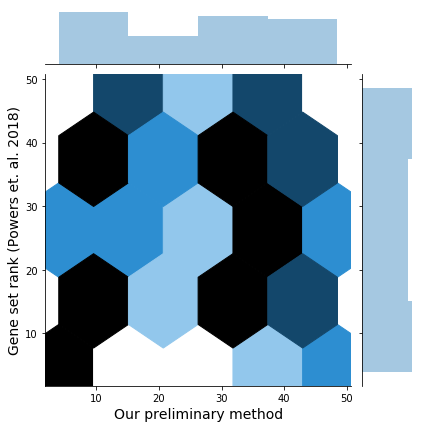

In [49]:
if compare_genes:
    # Get column headers for generic pathways identified by Powers et. al.
    ref_gene_col='index'
    ref_rank_col = 'Powers Rank'
    
    # Merge our ranking and reference ranking
    shared_pathway_rank_df = process.merge_ranks_to_compare(
        simulated_GSEA_stats_all_new,
        powers_rank_processed_file,
        ref_gene_col,
        ref_rank_col
        )
    
    if max(shared_pathway_rank_df["Rank (simulated)"]) != max(shared_pathway_rank_df[ref_rank_col]):
        shared_pathway_rank_scaled_df = process.scale_reference_ranking(shared_pathway_rank_df, ref_rank_col)
    else:
        shared_pathway_rank_scaled_df = shared_pathway_rank_df
        
    # Note: These lowly expressed genes were not pre-filtered before DESeq
    # (Micheal Love, author of DESeq2): In our DESeq2 paper we discuss a case where estimation of dispersion is difficult 
    # for genes with very, very low average counts. See the methods. 
    # However it doesn't really effect the outcome because these genes have almost no power for detecting 
    # differential expression. Effects runtime though.
    
    shared_pathway_rank_scaled_df = shared_pathway_rank_scaled_df[~shared_pathway_rank_scaled_df['Rank (simulated)'].isna()]
    
    # Get correlation
    r, p, ci_low, ci_high = calc.spearman_ci(0.95,
                                             shared_pathway_rank_scaled_df,
                                             1000,
                                             'GSEA')
    print(r, p, ci_low, ci_high)
    
    # Plot our ranking vs published ranking
    fig_file = os.path.join(
        local_dir, 
        "pathway_ranking_"+col_to_rank_pathways+".svg")

    fig = sns.jointplot(data=shared_pathway_rank_scaled_df,
                        x='Rank (simulated)',
                        y=ref_rank_col,
                        kind='hex'
                       )
    fig.set_axis_labels("Our preliminary method", "Gene set rank (Powers et. al. 2018)", fontsize=14)

**Conclusion:**
* If we compare the our ranking (`Rank (simulated)` column of the `summary_pathway_ranks` dataframe, we see that our highlight ranked pathways (rank >30) are consistent with those found to be generic (pathways found to be significantly enriched in >20% of experiments, figure 4A) in [Powers et. al.](https://academic.oup.com/bioinformatics/article/34/13/i555/5045793) (EF2, TNFA, MYC_TARGET_V1/2, P53, HYPOXIA, INFLAMMATORY, APOPTOSIS, COAGULATION, KRAS) 

* Despite the eye ball consistency above, there is not a correlation between our method ranking and Powers et. al. ranking. The comparison we're doing here is not a precise match because our ranking is ES(pathway) from a null set while the Powers et. al. ranking is based on ES(pathway) vs null set. So the Powers et. al. ranking is corrected for my this null set. Though the comparision is not ideal we'd still expect a correlation in the ranking

Instead we will try to use the normalized ES (NES) values to rank the pathways for this next try.

## Compare rank pathways try 2

In [50]:
# Aggregate statistics across all simulated experiments
simulated_GSEA_summary_stats = calc.aggregate_stats('NES',
                                                    simulated_GSEA_stats_all,
                                                    'GSEA')

simulated_GSEA_summary_stats.head()

NES                                padj
                                median      mean       std count    median
pathway                                                                   
HALLMARK_ADIPOGENESIS        -1.007175 -1.118413  0.377725    25  0.668583
HALLMARK_ALLOGRAFT_REJECTION -1.563294 -1.186467  1.136796    25  0.001668
HALLMARK_ANDROGEN_RESPONSE    1.421514  1.303045  0.666876    24  0.217205
HALLMARK_ANGIOGENESIS        -1.273828 -1.136839  0.689104    25  0.207668
HALLMARK_APICAL_JUNCTION     -0.986095 -0.493746  1.001758    25  0.507154

In [51]:
# Rank genes in template experiment
template_GSEA_stats = calc.rank_genes_or_pathways('NES',
                                                  template_GSEA_stats,
                                                  True)

In [52]:
# Rank genes in simulated experiments
simulated_GSEA_summary_stats = calc.rank_genes_or_pathways('NES',
                                                           simulated_GSEA_summary_stats,
                                                           False)

In [53]:
summary_pathway_ranks = process.generate_summary_table(template_GSEA_stats,
                                                       simulated_GSEA_summary_stats,
                                                       'NES',
                                                       local_dir)

summary_pathway_ranks.head()

(50, 13)


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,Gene ID,Adj P-value (Real),Rank (Real),Test statistic (Real),Median adj p-value (simulated),Rank (simulated),Mean test statistic (simulated),Std deviation (simulated),Number of experiments (simulated),Z score
pathway,,,,,,,,,,
HALLMARK_E2F_TARGETS,HALLMARK_E2F_TARGETS,0.002064,50.0,1.931764,0.025826,33.0,-0.175000,1.657346,21,1.271167
HALLMARK_G2M_CHECKPOINT,HALLMARK_G2M_CHECKPOINT,0.002064,49.0,1.928160,0.344405,35.0,0.067241,1.555049,21,1.196694
HALLMARK_GLYCOLYSIS,HALLMARK_GLYCOLYSIS,0.002064,48.0,1.847156,0.080578,47.0,1.379129,0.623879,18,0.750189
HALLMARK_KRAS_SIGNALING_DN,HALLMARK_KRAS_SIGNALING_DN,0.023637,47.0,1.438366,0.001901,15.0,-0.220419,1.448941,25,1.144826
HALLMARK_SPERMATOGENESIS,HALLMARK_SPERMATOGENESIS,0.216554,46.0,1.222346,0.065372,14.0,-0.569251,1.208514,25,1.482479


In [56]:
# Load Powers et. al. results file
powers_rank_file = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "metadata",
    "Hallmarks_NES_GSEAPreranked.csv")

In [57]:
# Read Powers et. al. data
# This file contains qvalue results for hallmark pathways across ~400 experiments
powers_rank_df = pd.read_csv(powers_rank_file, header=0, index_col=0)
powers_rank_df.drop(['Category'], axis=1, inplace=True)
print(powers_rank_df.shape)
powers_rank_df.head()

(50, 443)


,GSE10281_DEG_Expt1_Control_vs_Group1_nes,GSE10299_DEG_Expt1_Control_vs_Group1_nes,GSE10299_DEG_Expt1_Control_vs_Group2_nes,GSE10311_DEG_Expt1_Control_vs_Group1_nes,GSE10410_DEG_Expt1_Control_vs_Group1_nes,GSE10410_DEG_Expt1_Control_vs_Group2_nes,GSE10592_DEG_Expt1_Control_vs_Group1_nes,GSE10592_DEG_Expt2_Control_vs_Group1_nes,GSE11142_DEG_Expt1_Control_vs_Group1_nes,GSE11285_DEG_Expt1_Control_vs_Group1_nes,...,GSE79761_DEG_Expt1_Control_vs_Group2_nes,GSE79761_DEG_Expt1_Control_vs_Group3_nes,GSE83120_DEG_Expt1_Control_vs_Group1_nes,GSE83491_DEG_Expt1_Control_vs_Group1_nes,GSE83491_DEG_Expt2_Control_vs_Group1_nes,GSE8588_DEG_Expt1_Control_vs_Group1_nes,GSE8588_DEG_Expt1_Control_vs_Group2_nes,GSE8597_DEG_Expt1_Control_vs_Group1_nes,GSE8658_DEG_Expt1_Control_vs_Group1_nes,GSE9988_DEG_Expt1_Control_vs_Group1_nes
Term,,,,,,,,,,,,,,,,,,,,,
HALLMARK_APICAL_JUNCTION,1.560392,-0.817695,-1.530041,0.996295,0.972451,-1.084003,-1.068853,1.141070,-1.044469,0.839163,...,0.940730,-1.597947,-1.286612,1.038345,-1.059626,-1.643518,-0.877917,-1.297784,-0.928897,1.017287
HALLMARK_APICAL_SURFACE,1.063877,-0.991969,-1.273424,-1.045570,1.378803,0.946503,1.316094,1.778885,1.027871,-0.852689,...,1.171453,-1.572229,0.958104,0.963103,-0.772854,-1.204053,-1.004209,-1.717404,-0.958982,1.202334
HALLMARK_PEROXISOME,-1.237684,-0.649237,-1.396599,1.379074,-1.699454,-1.347336,1.369712,-1.590091,-1.078683,1.064139,...,-1.094045,1.152140,1.451252,1.312006,1.301877,-1.646535,-1.564985,1.117150,1.734258,-1.038821
HALLMARK_ADIPOGENESIS,1.572997,-1.095219,-1.302986,1.578491,-1.627299,-1.923082,1.378849,0.838617,-0.901056,-1.459502,...,-1.003471,0.818511,1.468616,1.683901,1.903761,0.937315,0.998228,-0.914474,2.207445,1.037141
HALLMARK_ANGIOGENESIS,1.627098,-1.162018,-0.926931,-0.609095,1.335239,-1.611969,-1.755274,1.550218,-0.757108,1.079956,...,1.672618,-1.597971,0.715329,1.527196,0.938825,-1.753454,-1.307528,-1.636464,1.280110,1.329609


In [65]:
# Rank pathways by NES score per experiment
# Get median rank per pathway
powers_rank_stats_df = powers_rank_df.rank().median(axis=1).to_frame('Powers Rank')

powers_rank_stats_df.head()

,Powers Rank
Term,
HALLMARK_APICAL_JUNCTION,25.0
HALLMARK_APICAL_SURFACE,21.0
HALLMARK_PEROXISOME,18.0
HALLMARK_ADIPOGENESIS,23.0
HALLMARK_ANGIOGENESIS,27.0


In [66]:
# Save reference file for input into comparison
powers_rank_processed_file = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "metadata",
    "Hallmarks_NES_GSEAPreranked_processed.tsv")

powers_rank_stats_df.to_csv(powers_rank_processed_file, sep="\t", )

In [67]:
if compare_genes:
    # Get column headers for generic pathways identified by Powers et. al.
    ref_gene_col='index'
    ref_rank_col = 'Powers Rank'
    
    # Merge our ranking and reference ranking
    shared_pathway_rank_df = process.merge_ranks_to_compare(
        summary_pathway_ranks,
        powers_rank_processed_file,
        ref_gene_col,
        ref_rank_col
        )
    
    if max(shared_pathway_rank_df["Rank (simulated)"]) != max(shared_pathway_rank_df[ref_rank_col]):
        shared_pathway_rank_scaled_df = process.scale_reference_ranking(shared_pathway_rank_df, ref_rank_col)
    else:
        shared_pathway_rank_scaled_df = shared_pathway_rank_df
        
    # Note: These lowly expressed genes were not pre-filtered before DESeq
    # (Micheal Love, author of DESeq2): In our DESeq2 paper we discuss a case where estimation of dispersion is difficult 
    # for genes with very, very low average counts. See the methods. 
    # However it doesn't really effect the outcome because these genes have almost no power for detecting 
    # differential expression. Effects runtime though.
    
    shared_pathway_rank_scaled_df = shared_pathway_rank_scaled_df[~shared_pathway_rank_scaled_df['Rank (simulated)'].isna()]
    
    # Get correlation
    r, p, ci_low, ci_high = calc.spearman_ci(0.95,
                                             shared_pathway_rank_scaled_df,
                                             1000,
                                             'GSEA')
    print(r, p, ci_low, ci_high)
    
    # Plot our ranking vs published ranking
    fig_file = os.path.join(
        local_dir, 
        "pathway_ranking_"+col_to_rank_pathways+".svg")

    fig = sns.jointplot(data=shared_pathway_rank_scaled_df,
                        x='Rank (simulated)',
                        y=ref_rank_col,
                        kind='hex'
                       )
    fig.set_axis_labels("Our preliminary method", "Gene set rank (Powers et. al. 2018)", fontsize=14)

KeyError: "['Fraction enriched'] not in index"